# CV Course Project: Assignment - Image Recognition

---

**Group:**
- Alumno 1:
- Alumno 2:
- Alumno 3: Reyes Castro, Didier Yamil (didier.reyes.castro@alumnos.upm.es)

**Course:** Computer Vision (CV) - 2025/26

**Institution:** Polytechnic University of Madrid (UPM)

**Date:** January 2026

---

## Goals

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/2DDPE2zHw5dbM3G](https://drive.upm.es/s/2DDPE2zHw5dbM3G)

## 0 Setup and Data Loading

### 0.1 Install and Import Required Libraries

If using Google Colab, uncomment the following line to install the required packages.

In [1]:
# !pip install tensorflow numpy rasterio scikit-learn matplotlib keras

If using Conda, create a new environment and install the required packages:
```bash
conda create -n cv_project python tensorflow numpy rasterio scikit-learn matplotlib jupyterlab
conda activate cv_project
```

Loading the necessary libraries.

In [2]:
# Python libraries
import uuid
import warnings
import json
import os
import math

# External libraries
import numpy as np
import rasterio
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


2025-10-01 16:52:21.923536: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-01 16:52:22.042256: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759330342.068791     972 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759330342.077339     972 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-01 16:52:22.203839: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Check if GPU is available for training the models.

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 0.2 Load the Dataset & Image Loader

Before loading the dataset, set the path to the folder containing the images.

In [4]:
IMAGES_PATH = '/mnt/c/Users/didie/Desktop/main/MUIA/CV/Labs/Image_Recognition/xview_recognition/'

In [5]:
class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [6]:
categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

In [7]:
def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(IMAGES_PATH + filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

In [8]:
# Load database
json_file = IMAGES_PATH + 'xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [9]:
counts = dict.fromkeys(categories.values(), 0)
anns_dataset = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns_dataset.append(image)
print(counts)

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


In [10]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

### 0.3 Setup

In [ ]:
# Fix random seed for reproducibility
RANDOM_SEED = 42
def set_seed(seed_value):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
set_seed(RANDOM_SEED)

# Number of categories for classification
NUM_CATEGORIES = len(categories)

### 0.4 Possible Architectures / Parameters to Tune

- Normalisation of the input data (rescaling pixels from [0, 255] to [0, 1])
- Adam tuning: learning rate, beta 1, beta 2, epsilon, amsgrad
- Increase number of epochs
- Adding more Dense layers
- Change the activation functions of Dense layers: ReLU, leaky ReLU, ELU (which to choose for each layer?)
- Change loss function from Crossentropy to Focal Loss
- Weight Initialisation (HE initialisation)
- Use BatchNorm layers (but where? in all layers?)
- Dropout?, Early stopping?
- Increase batch size (although it could generalise worst but be parallelised) (also batch size being related to learning rate: learning*N/batch)
- Other advanced techniques seen in class: SGD with warm restarts, SAM

## 1 Model 0: Simple (and Bad) ffNN > Multinomial Logistic Regression Model

The following architecture is used as a starting point:
- Validation split: 10% (NO stratification)
- Input layer: 150,528 neurons (224x224x3) > Activation function: ReLU
- Output layer: 13 neurons (the categories to classify) > Activation function: Softmax
- Optimiser: Adam with learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0
- Loss function: Categorical Crossentropy

### 1.1 Setup

In [12]:
anns_train, anns_valid = train_test_split(anns_dataset, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

Number of training images: 16871
Number of validation images: 1875


In [13]:
print('Compiling the model...')

model = Sequential([
    Input(shape=(224, 224, 3)), # 224x224 images with 3 channels (RGB)
    Flatten(), # Flatten the 3D tensor to 1D
    Activation('relu'),
    Dense(NUM_CATEGORIES, activation='softmax') # Output layer with softmax activation
])

model.summary()

opt = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

Compiling the model...


I0000 00:00:1759330345.341155     972 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1751 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 13)             │     1,956,877 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,956,877 (7.46 MB)

 Trainable params: 1,956,877 (7.46 MB)

 Non-trainable params: 0 (0.00 B)

The following are helper functions that monitor the training process:
- **ModelCheckpoint:** Save the best model based on validation accuracy.
- **ReduceLROnPlateau:** Reduce learning rate when validation accuracy stops improving.
- **EarlyStopping:** Stop training when validation accuracy stops improving.
- **TerminateOnNaN:** Stop training if NaN loss is encountered.

In [14]:
# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

Transforming the ImageObjects to actual image generators for training and validation.

In [15]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]

# Generators
BATCH_SIZE = 16
train_generator = generator_images(objs_train, BATCH_SIZE, do_shuffle=True)
valid_generator = generator_images(objs_valid, BATCH_SIZE, do_shuffle=False)

### 1.2 Training

In [16]:
print('Training model...')

EPOCHS = 20
train_steps = math.ceil(len(objs_train)/BATCH_SIZE)
valid_steps = math.ceil(len(objs_valid)/BATCH_SIZE)

h = model.fit(train_generator, 
              steps_per_epoch=train_steps, 
              validation_data=valid_generator, 
              validation_steps=valid_steps, 
              epochs=EPOCHS, 
              callbacks=callbacks, 
              verbose=1)

# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model...
Epoch 1/20


I0000 00:00:1759330349.726191    1140 service.cc:148] XLA service 0x798788006ea0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1759330349.726228    1140 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-10-01 16:52:29.777225: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1759330349.880372    1140 cuda_dnn.cc:529] Loaded cuDNN version 90101
2025-10-01 16:52:30.406609: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_92', 4 bytes spill stores, 4 bytes spill loads

2025-10-01 16:52:30.444136: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_92', 

   1/1055 ━━━━━━━━━━━━━━━━━━━━ 34:07 2s/step - accuracy: 0.1250 - loss: 158.8383

I0000 00:00:1759330351.171614    1140 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1054/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 393ms/step - accuracy: 0.2242 - loss: 4290.3291

2025-10-01 16:59:25.462757: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_92', 156 bytes spill stores, 156 bytes spill loads



1055/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.2243 - loss: 4289.9243

2025-10-01 17:00:08.013303: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_54', 104 bytes spill stores, 104 bytes spill loads




Epoch 1: val_accuracy improved from None to 0.27040, saving model to model.keras
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 459s 434ms/step - accuracy: 0.2543 - loss: 3863.4570 - val_accuracy: 0.2704 - val_loss: 3510.7112 - learning_rate: 0.0010
Epoch 2/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.2952 - loss: 3318.4053
Epoch 2: val_accuracy did not improve from 0.27040
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 427s 405ms/step - accuracy: 0.3034 - loss: 3445.2390 - val_accuracy: 0.2597 - val_loss: 3431.4346 - learning_rate: 0.0010
Epoch 3/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.3133 - loss: 3520.5972
Epoch 3: val_accuracy improved from 0.27040 to 0.27947, saving model to model.keras
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 342s 325ms/step - accuracy: 0.3124 - loss: 3593.4204 - val_accuracy: 0.2795 - val_loss: 5921.1841 - learning_rate: 0.0010
Epoch 4/20
1055/1055 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.3256 - loss: 3453.2078
Epoch 4: val_accuracy improved from 0.27947 t

- Training time: ~ 108 minutes
- GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
- Best validation model: Epoch 15 - Validation accuracy: 0.3941

### 1.3 Validation
Compute validation metrics.

In [17]:
def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

In [18]:
model.load_weights('model.keras')
y_true, y_pred = [], []
for ann in anns_valid:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

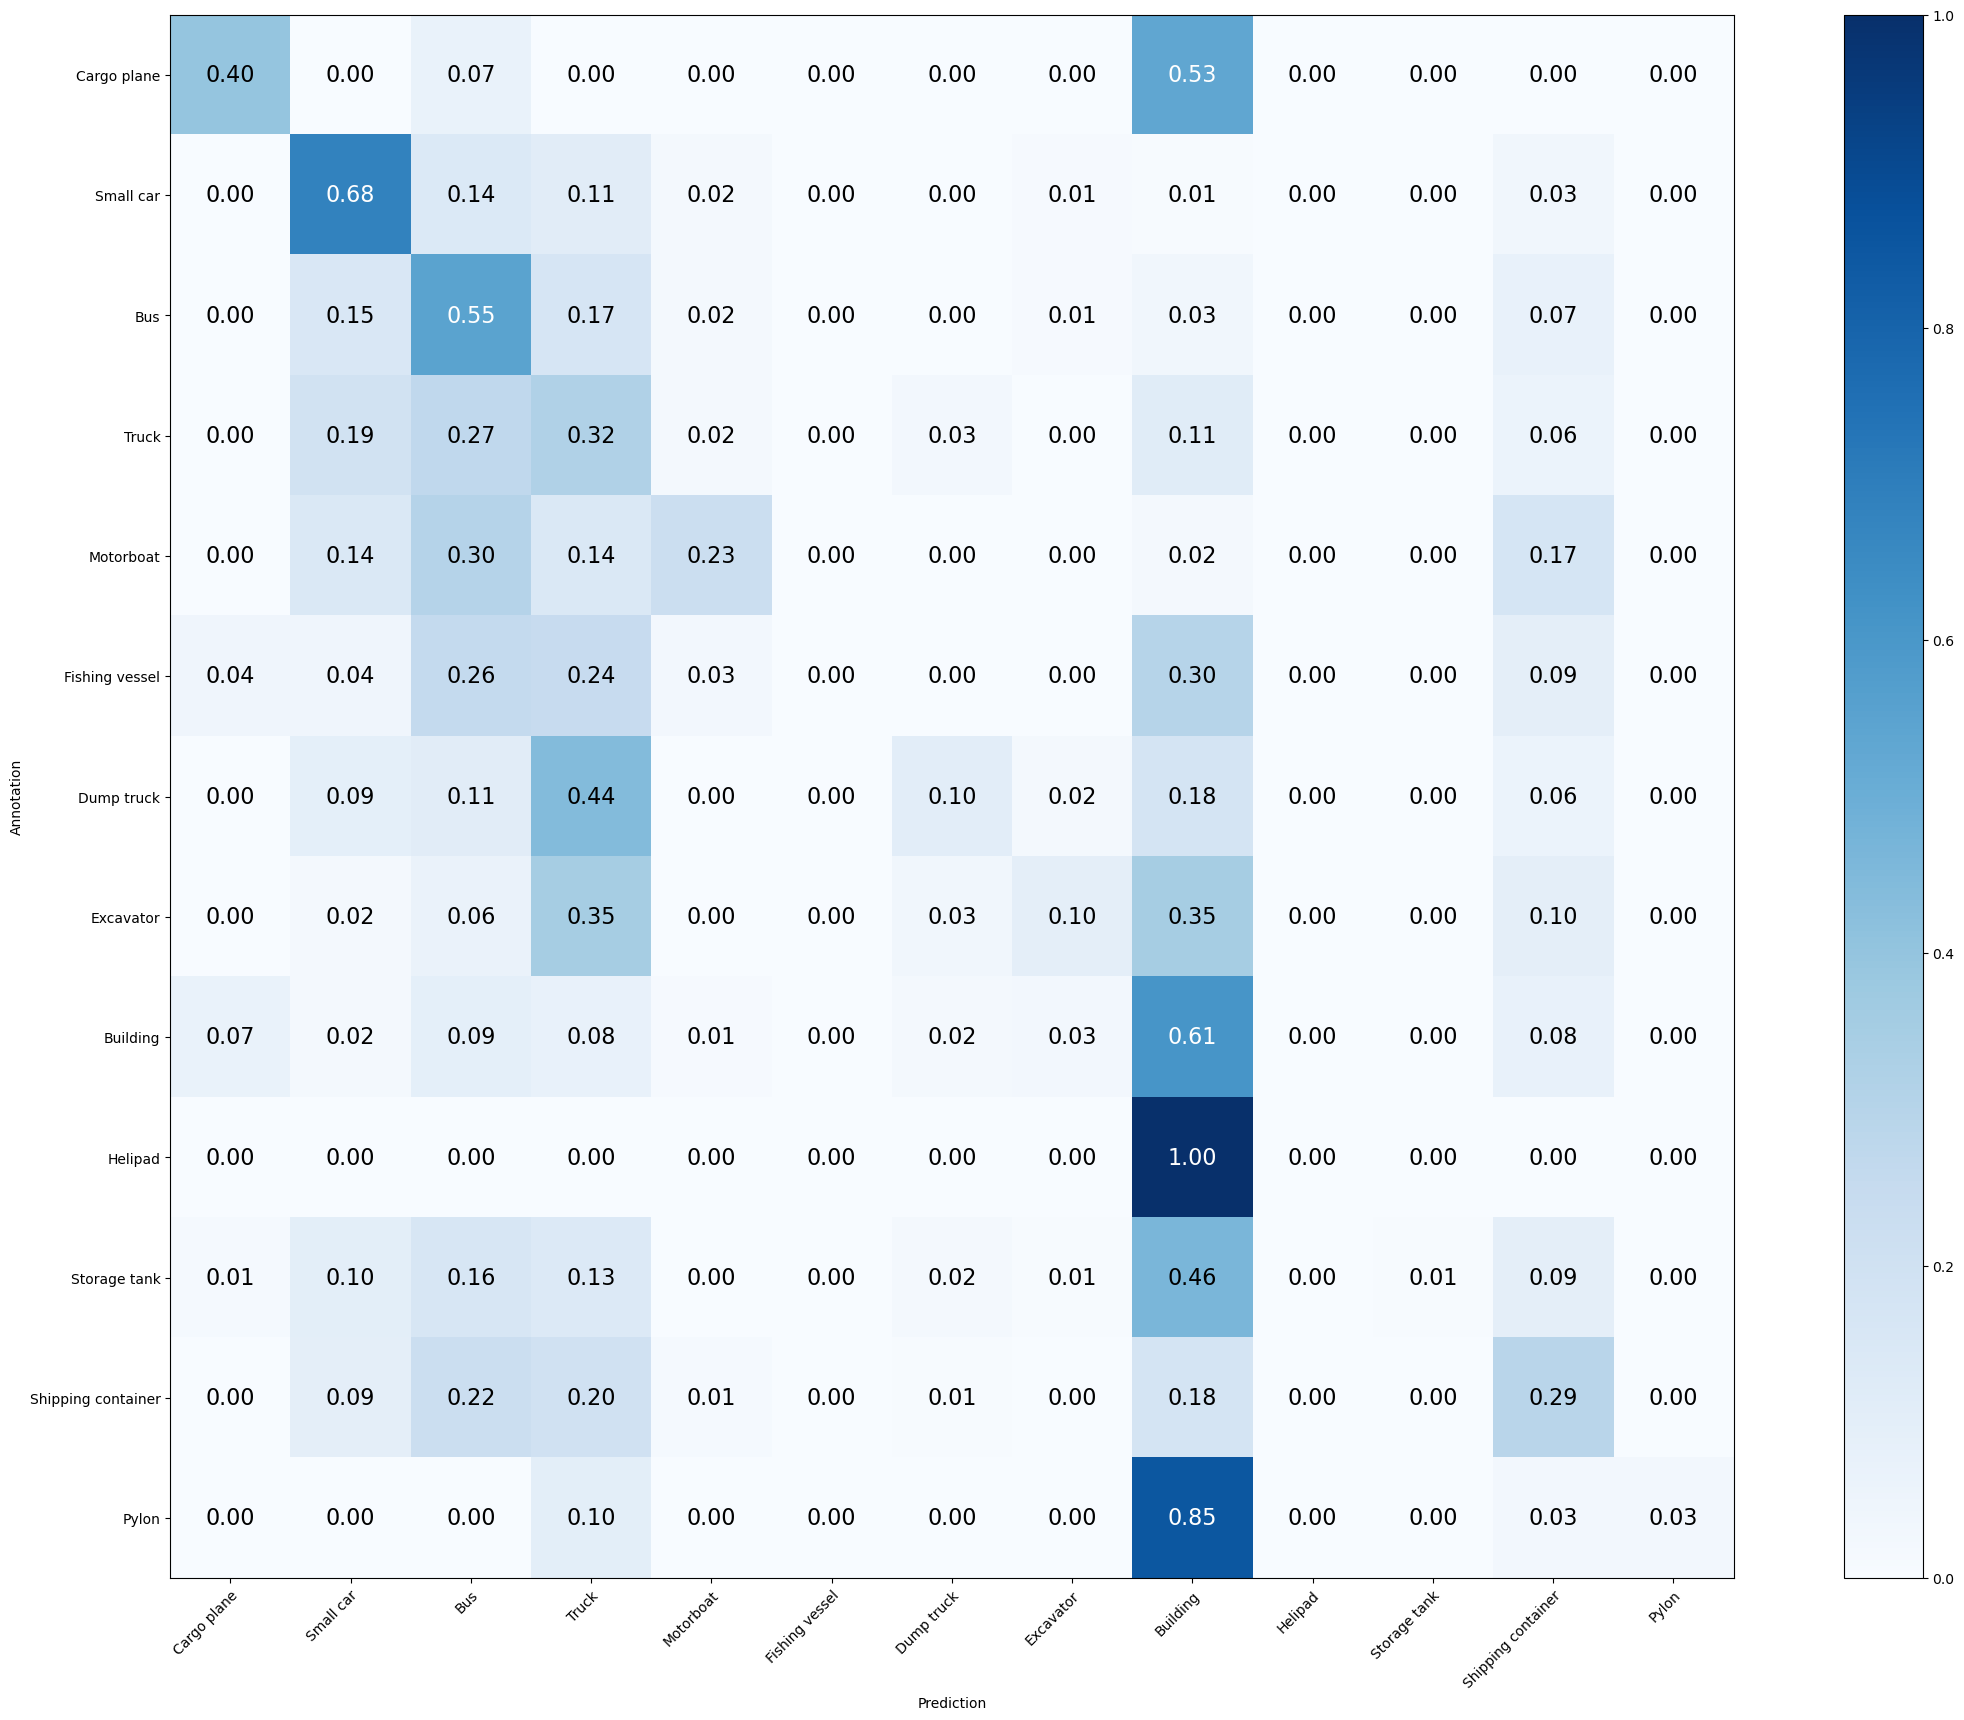

In [19]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [20]:
# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 39.413%
Mean Recall: 25.375%
Mean Precision: 37.437%
> Cargo plane: Recall: 39.535% Precision: 36.957% Specificity: 98.417% Dice: 38.202%
> Small car: Recall: 68.091% Precision: 62.730% Specificity: 90.682% Dice: 65.301%
> Bus: Recall: 54.976% Precision: 30.366% Specificity: 84.014% Dice: 39.123%
> Truck: Recall: 31.878% Precision: 21.988% Specificity: 84.265% Dice: 26.025%
> Motorboat: Recall: 22.642% Precision: 50.000% Specificity: 98.643% Dice: 31.169%
> Fishing vessel: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Dump truck: Recall: 10.169% Precision: 38.710% Specificity: 98.919% Dice: 16.107%
> Excavator: Recall: 9.524% Precision: 26.087% Specificity: 99.062% Dice: 13.953%
> Building: Recall: 60.694% Precision: 44.681% Specificity: 82.995% Dice: 51.471%
> Helipad: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Storage tank: Recall: 0.671% Precision: 50.000% Specificity: 99.942% Dice: 1.325%
> Shipping container: Recall

### 1.4 Testing
Trying to improve the results provided in the competition.

In [ ]:
anns = []
for (dirpath, dirnames, filenames) in os.walk('../PROJECT/xview_recognition/xview_test'):
    for filename in filenames:
        image = GenericImage(dirpath[29:] + '/' + filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

In [ ]:
model.load_weights('model.keras')
predictions_data = {"images": {}, "annotations": {}}
for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [ ]:
with open("prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)